# Gaussian

### Introduction
A Gaussian process (GP) is a probabilistic model that defines a distribution over functions. It is a powerful and flexible tool for regression, classification, and other types of statistical modeling tasks. The key idea behind a Gaussian process is to treat functions as random variables, allowing us to reason about uncertainty and make predictions based on observed data.

At its core, a Gaussian process assumes that any finite set of function values follows a multivariate Gaussian distribution. In other words, if we have a set of input points, the corresponding output values of a function evaluated at those points will form a multivariate Gaussian distribution. This distribution is fully characterized by a mean function and a covariance function.

The mean function represents the expected value of the function at each input point, providing a prior assumption about the overall behavior of the function. The covariance function, also known as a kernel function, describes the similarity between function values at different input points. It determines how much influence one observed data point has on the prediction at another point.

When making predictions with a Gaussian process, we start with some observed data and compute the posterior distribution over functions. This posterior distribution takes into account the prior assumptions encoded in the mean and covariance functions and is updated based on the observed data. Given this posterior distribution, we can make predictions at new input points by considering the mean and uncertainty (variance) associated with those predictions.

One of the advantages of Gaussian processes is their flexibility. The choice of the covariance function allows us to model different types of functions, capturing various patterns and behaviors. Common kernel functions include the squared exponential, Matérn, and periodic kernels, each suitable for different types of data and assumptions.

Keep in mind that Gaussian Process regression can be computationally expensive for large datasets since it involves inverting a covariance matrix. It is also important to choose an appropriate kernel and tune its hyperparameters for the specific problem you are working on. The computational cost grows with $\mathcal{O}(n^3)$, the exercises never use more than 2000 samples.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

In [2]:
from data import load_narx_data

n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 10000 # total number of points to consider from the larger dataset (starting from index 0)

Xtrain,Ytrain = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=True)
Xval,Yval = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
Xtest,Ytest = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=False)

Considering 10000 datapoints
Using 6000 datapoints for training set
Considering 10000 datapoints
Using 2000 datapoints for validation set
Considering 10000 datapoints
Using 2000 datapoints for test set


In [3]:
kernel = RBF() + WhiteKernel()
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=10)

reg.fit(Xtrain, Ytrain)

print(reg.kernel_)

Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 

NRMS = np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)

print(f'Validation NRMS= {NRMS}')

RBF(length_scale=4.43) + WhiteKernel(noise_level=2.04e-05)
Validation NRMS= 0.011303895970370525


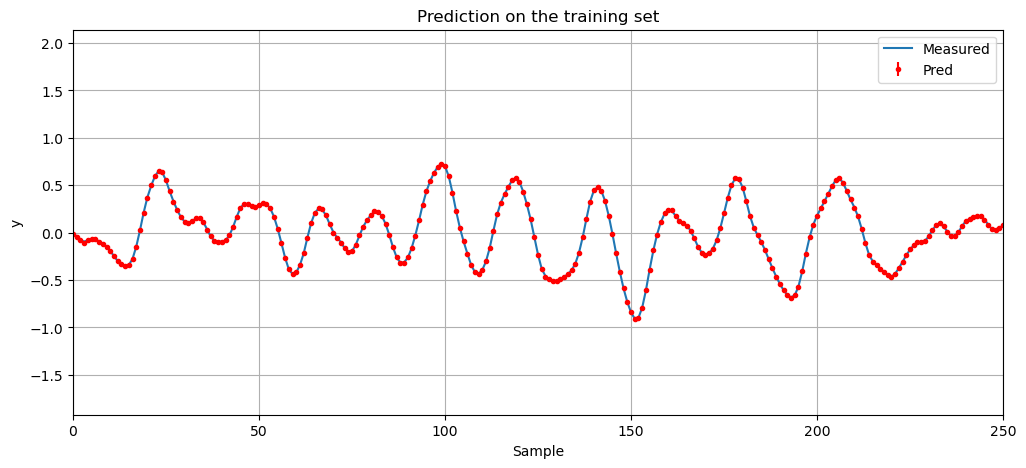

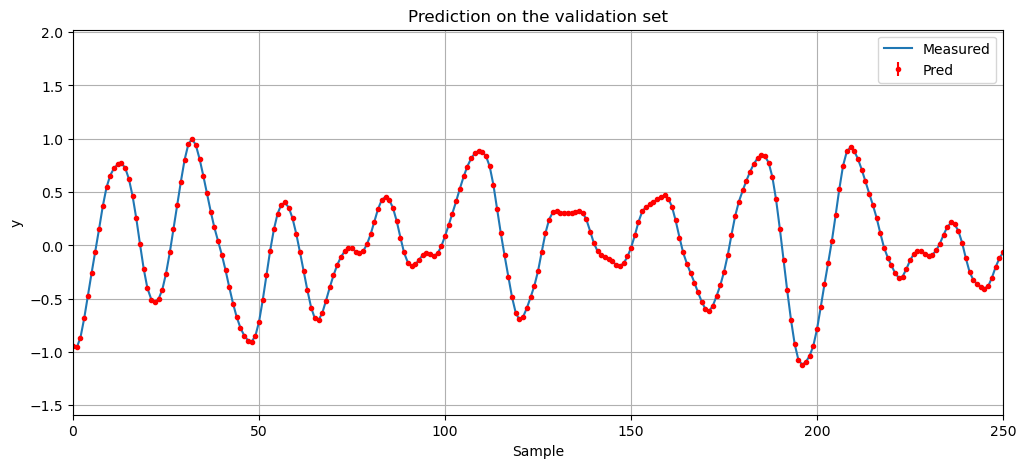

Validation NRMS= 0.011303895970370525


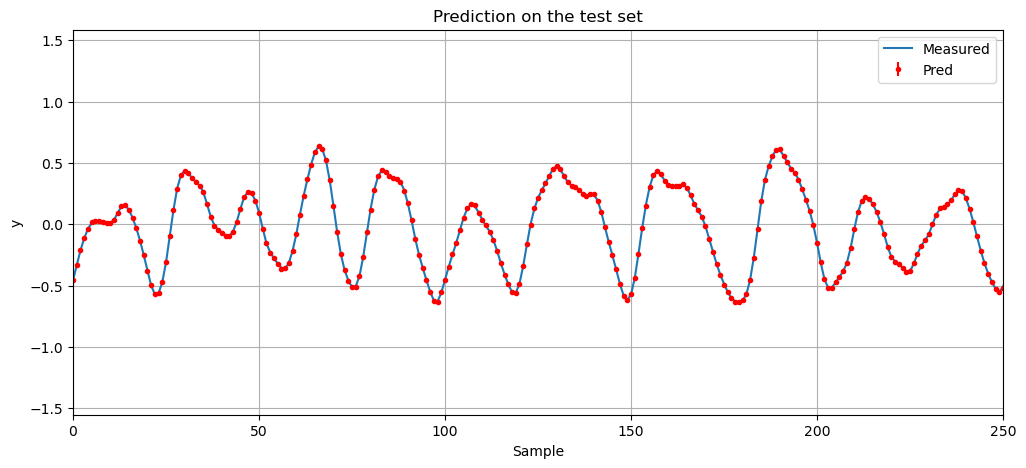

Test NRMS = 0.008432117628729642


In [4]:
# Plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain, return_std=True) 
plt.figure(figsize=(12, 5)) 
plt.plot(Ytrain) 
plt.title('Prediction on the training set')
plt.errorbar(np.arange(len(Xtrain)), Ytrain_pred, yerr=2 * Ytrain_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

plt.figure(figsize=(12, 5)) 
plt.title('Prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 
plt.errorbar(np.arange(len(Xval)), Yval_pred, yerr=2 * Yval_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred']) 
plt.xlim([0, 250])
plt.show()




print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')

plt.figure(figsize=(12, 5))
plt.title('Prediction on the test set')
plt.plot(Ytest)
ytest_pred, ytest_pred_std = reg.predict(Xtest, return_std=True)
plt.errorbar(np.arange(len(Xtest)), ytest_pred, yerr=2 * ytest_pred_std, fmt='.r')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

print(f'Test NRMS = {np.mean((ytest_pred - Ytest) ** 2, axis=0) ** 0.5 / np.std(Ytest)}')

## Reporting

When using a Gaussian process (GP) model with the NARX (Nonlinear AutoRegressive with eXogenous inputs) framework to capture the system dynamics of the unbalanced disc, choosing an appropriate kernel combination is crucial. The choice of kernels affects the model's ability to capture nonlinear relationships and dependencies in the data. Iterative experimentation and model validation will be essential to fine-tune the kernel selection.

The Radial Basis Function (RBF) kernel is often a good starting point due to its ability to capture smooth functions and long-range dependencies. The RBF kernel is widely used in Gaussian process regression and has been successful in various applications. Adding a WhiteKernel to the RBF kernel can potentially help in improving the modeling result. 

The WhiteKernel represents uncorrelated noise in the data. By including a WhiteKernel, you allow the GP model to account for the presence of noise that may exist in the system dynamics or the measurements. This can be beneficial in capturing any random fluctuations or measurement errors that might affect the accuracy of the model.

The Rational Quadratic Kernel is capable of capturing both short- and long-range dependencies in the data, making it suitable for systems with varying degrees of complexity. It can effectively model both smooth and non-smooth components in the system dynamics.

## Results

All tests are done with 3000 points of training data and 1000 points of validation data. Final results should be checked with a bigger data base.

### Pure RBF:
length_scale = 40.5

Validation NRMS= 0.008347802680728239

Running the pure RBF results in either bad results without an error or an error stating that the best value is close to the lower bound. I found the optimal value to be around 40.5 after trial and error, but this seems highly arbitrary.

ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 40.5. Decreasing the bound and calling fit again may find a better value.

Lowering the bound however returns a worse NRMS

### RBF + WhiteKernel
length_scale = 4.1, noise_level = 2.14e-05

Validation NRMS= 0.008590012517088724

The noise_level is very low, indicating very clean data. The validation NRMS is very close, but just slightly worse. Running a pure RBF also takes less time so might be better.

### Pure RationalQuadratic
alpha=0.00924, length_scale=3.14

Validation NRMS= 0.03856075408492166

A Pure RationalQuadratic does not seem to be able to capture the system dynamics as well as the RBF or the RBF with white-noise. However, it does provide a nice bases to maybe combine multiple kernels.

### RationalQuadratic + WhitKernel
RationalQuadratic(alpha=50.1, length_scale=4.16) + WhiteKernel(noise_level=2.14e-05)

Validation NRMS= 0.008589347072043198

Takes quite a wile to run. Results are similar to RBF + WhiteKernel. An alpha value of 50.1 suggests that the kernel assumes a relatively low noise level or uncertainty in the training data. A higher alpha value would indicate higher noise levels or greater uncertainty.

A low alpha value indicates that the model places more emphasis on fitting the data precisely, potentially leading to overfitting if the noise in the training data is underestimated.

### RBF + RationalQuadratic + WhiteKernel using Product()
RBF(length_scale=5.63e+03) * RationalQuadratic(alpha=50, length_scale=4.16) + WhiteKernel(noise_level=2.14e-05)

Validation NRMS= 0.008589347608065321

Seems to ignore the RBF and just make use of RationalQuadratic and WhiteKernel

### RBF + RationalQuadratic + WhiteKernel using addition
RBF(length_scale=4.6) + RationalQuadratic(alpha=6.76e+04, length_scale=5.91) + WhiteKernel(noise_level=2.14e-05)

Validation NRMS= 0.008516026680254786

Does not seem to improve things much. I believe we either should use normal RBF, but in that case I want to understand the error we have and why it returns such a low NRMS for such a high length scale. Otherwise, using RationalQuadratic or RBF with whitenoise should be sufficient.

### Testing RBF + WhiteKernel with a as big as possible dataset

6000 training points

RBF(length_scale=4.43) + WhiteKernel(noise_level=2.04e-05)
Validation NRMS= 0.011303895970370525